<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/Bitcoin_Price_and_its_Movement_Direction_Prediction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bitcoin Price and its Movement Direction Prediction**
*Using Linear Regression, Logistics Regression, ARIMA, Simple RNN and LSTM Models.*

# **Packages**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import datetime as datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#**Data Cleaning**

Import Dataset

In [15]:
df = pd.read_csv("/content/bitcoin.csv")

Modify Timestamp

In [16]:
# Change the Timestamp column attribute to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
# Enable to refer to the row by index 
df = df.set_index('Timestamp')

Spot the missing values

In [17]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]


Fill in the missing data

In [18]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    
fill_missing(df)

Remove NA rows

In [19]:
df = df.dropna()

# **Feature Engineering**

Add `Price` column by averaging Low and Close

In [8]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)

Add `Return` Column by calculating the difference from now to previous second's `Price`

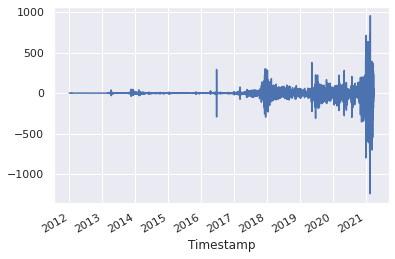

In [9]:
df["Return"] = df["Price"].diff()
df["Return"].plot(x="Timestamp", y="Return")

Add `Direction` column showing if bitcoin price is going up or down.

In [10]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add `Percentage_Return` column to show the perentage return per seconds

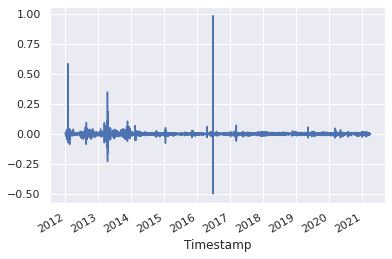

In [11]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Percentage_Return"].plot()

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [12]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)
df.dropna()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:53:00,4.390,4.390,4.39,4.39,0.555046,2.436653,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:54:00,4.390,4.390,4.39,4.39,0.654511,2.873305,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:55:00,4.390,4.390,4.39,4.39,0.753977,3.309958,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:56:00,4.390,4.390,4.39,4.39,0.853442,3.746611,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:57:00,4.390,4.390,4.39,4.39,0.952907,4.183264,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:51:00,58677.050,58699.900,58660.00,58699.90,2.672676,156832.692130,58680.021260,58684.2125,2.8925,Up,0.000049,0.000234,0.000234,0.000545,-0.000263,-0.000478
2021-03-30 23:52:00,58697.865,58715.565,58679.17,58699.20,1.440329,84520.873706,58691.157958,58697.9500,13.7375,Up,0.000234,0.000234,0.000545,-0.000263,-0.000478,-0.000228
2021-03-30 23:53:00,58718.680,58731.230,58698.34,58698.50,0.207983,12209.055282,58702.294657,58711.6875,13.7375,Up,0.000234,0.000545,-0.000263,-0.000478,-0.000228,0.000372


Cleaned Dataset Display

In [13]:
df.shape

(4857377, 16)

In [14]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39,NaN,Down,NaN,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0


#**Exploratory Data Analysis**

Zheming's Part

Produce a kernal density plot for Price (refer to Lecture 7 02-Exploratory-Data-Analysis.ipynb)

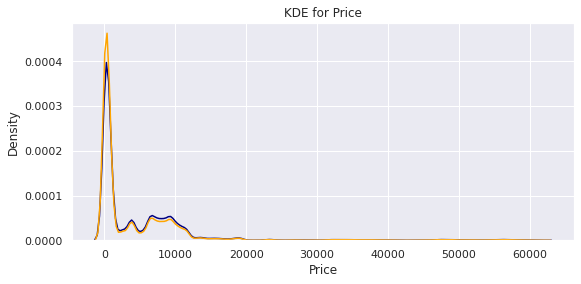

In [ ]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Direction'] == 'Up'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Direction'] == 'Down'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('Price')


Analyze correlations with seaborn heatmap

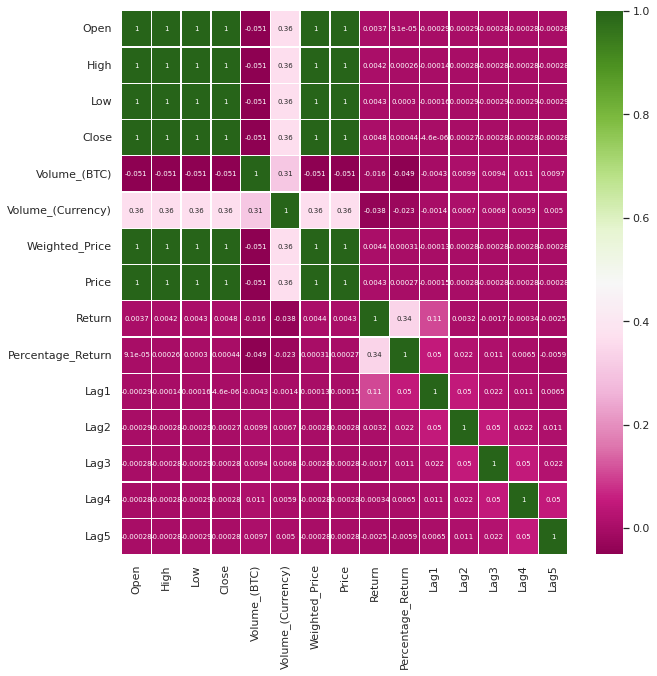

In [ ]:
corr = df.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=7
sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );

In [ ]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


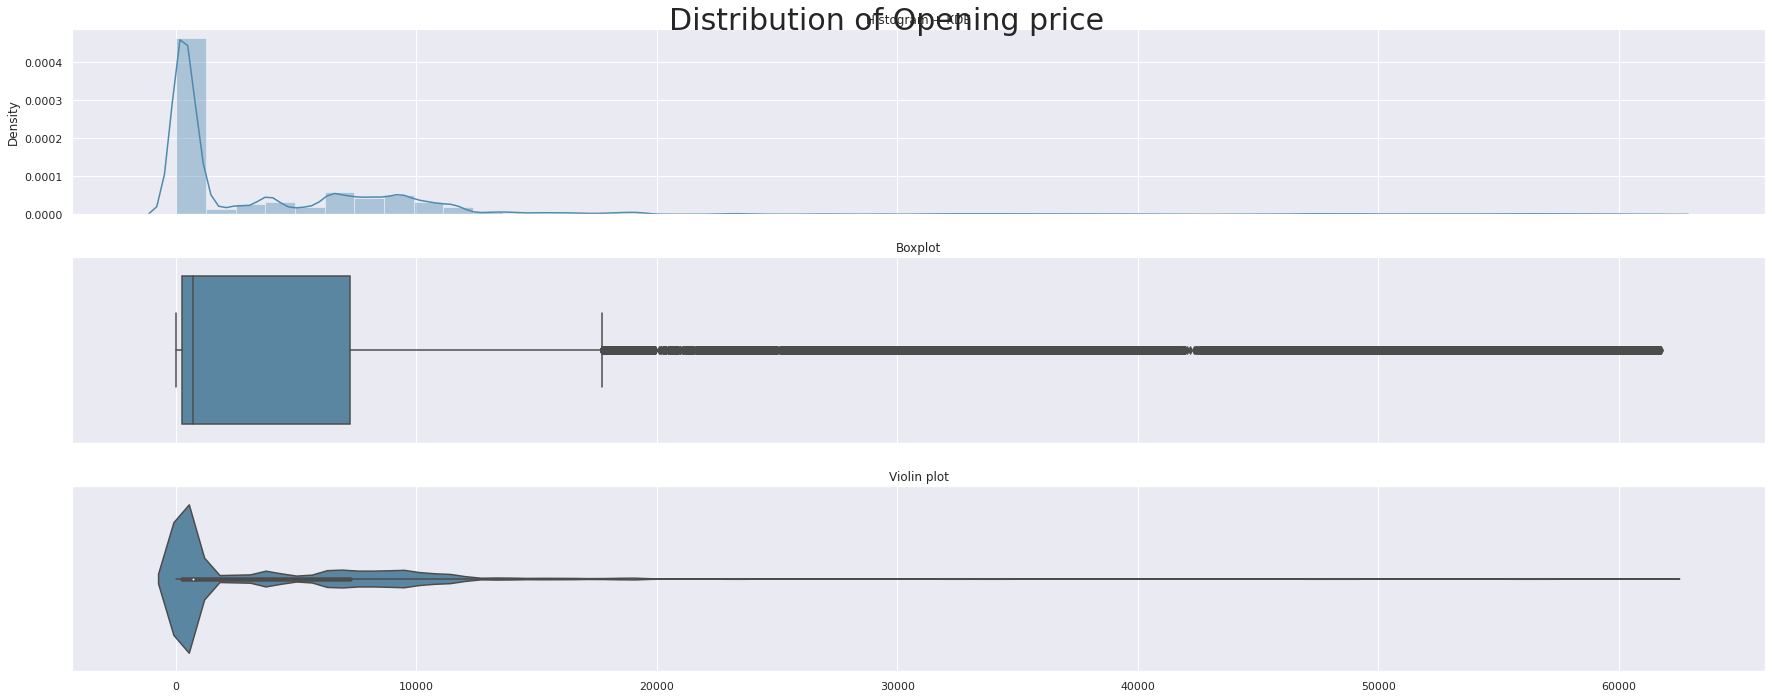

In [ ]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

# **Linear Regression**

Ji Qi's part here

#**Logistics Regression**

Ji Qi's part here

# **ARIMA Model**

Geech's part here

Arima model stands for Auto Regressive Intergrated Moving Average. It is a forcasting algorimth that uses the past values to predict future values such as intercept (c), Lags (AR), forecast errors (MA). 

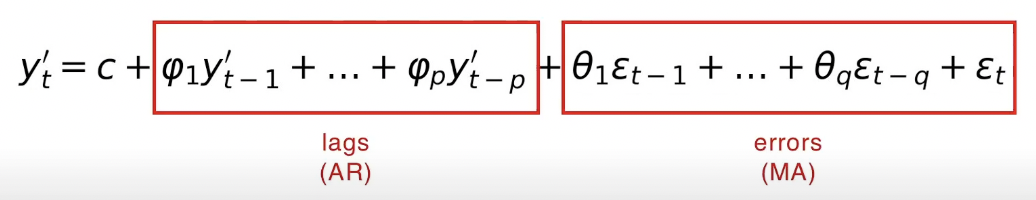

In [20]:
df = df.resample("24H").mean()

In [21]:
df.head(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370
2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576
2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549
2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530
2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680


In [22]:
df.shape

(3379, 7)

We are going to only use the Closing price of BItcoin to predict the future value. (Univariate time series forcasting) 

In [23]:
df= df[["Close"]].copy()

In [24]:
df.describe()

,Close
count,3376.000000
mean,4605.639551
std,8207.350418
min,4.360638
25%,245.230391
50%,697.703091
75%,7242.406733
max,60460.509722


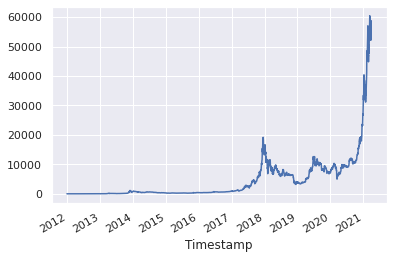

In [25]:
#drop any missing values for closing columns 
df.Close.dropna().plot()

In [26]:
from numpy import log

We split the group into two inorder to calculate the mean and variance of the two groups. If the mean and variance looks very different, our data is non-stationary time series so we cannot reject the null. A non- stationary time series is one that depends on time at which the series is observed.  

In [27]:
# use log to make the distribution more flat.
X = df.Close
X=log(X)
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=4.833398, mean2=8.641288
variance1=2.801974, variance2=1.048945


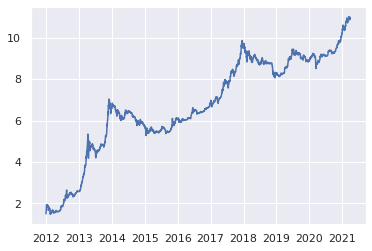

In [28]:
#plot a graph after using log to flatten the closing price 
plt.plot(X)
plt.show()

Another way to see if our data is stationary by using adfuller() function. The function perform ADF test.

Null hypothesis of ADF is that the time series is not stationary. So if P-value is bigger than 0.05. we cannot reject Null.

 **Augmented Dickey Fuller test**

In [29]:
from statsmodels.tsa.stattools import adfuller

In [30]:
# d=0 if the time series is stationary 
test_adf = adfuller(df.Close.dropna())

print(f" ADF Statistics: {test_adf[0]}")
print(f" P-value: {test_adf[1]}")

 ADF Statistics: 6.1895129620459315
 P-value: 1.0


The P-value that we got showed that the time series is 100% non- staitonary. So We are going to tranform the non- stationary data by taking the differences of consecutive observations. 

In [31]:
#use Pandas's diff()
df["diff_1"] = df["Close"].diff(periods=1)
df["diff_2"] = df["Close"].diff(periods=2)
df["diff_3"] = df["Close"].diff(periods=3)

df.head(6)

,Close,diff_1,diff_2,diff_3
Timestamp,,,,
2011-12-31,4.478946,NaN,NaN,NaN
2012-01-01,4.765576,0.286630,NaN,NaN
2012-01-02,5.006549,0.240972,0.527602,NaN
2012-01-03,5.206530,0.199982,0.440954,0.727584
2012-01-04,5.241699,0.035169,0.235151,0.476123
2012-01-05,6.162639,0.920940,0.956109,1.156090


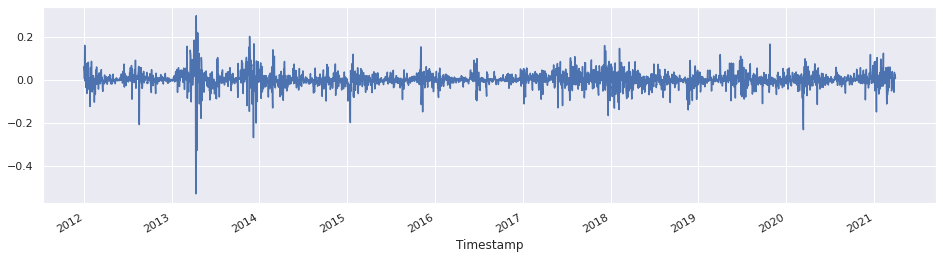

In [32]:
#use log to remove non-linearity 
transformed_df = pd.Series(log(df["Close"])).diff().dropna()

transformed_df.plot(figsize=(16, 4))

The time series is now more stationary. 

In [33]:
#run the adf test with modified data 
results = adfuller(transformed_df)

print(f" ADF Statistics: {results[0]}")
print(f" P-value: {results[1]}")

 ADF Statistics: -10.552563318040379
 P-value: 8.105065720567304e-19


**Hyperparameter Tuning**

Hyperparameter of Arima Model are P,d and q. P refers to the order of the autoregressive term. d refers to the numbers of differences inorder to make the time series stationary. q is the order of the moving average term. 

In [34]:
#Autocorrelation Function (ACF)
from statsmodels.graphics.tsaplots import plot_acf

**Finding d***

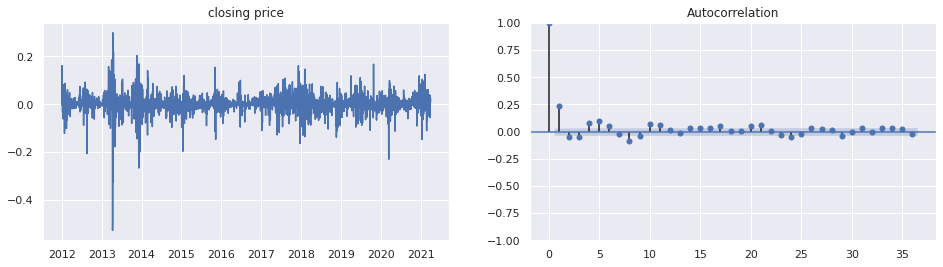

In [38]:
#order of differencing #2nd diff 
fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(transformed_df)
ax1.set_title('closing price')
plot_acf(transformed_df, ax= ax2);

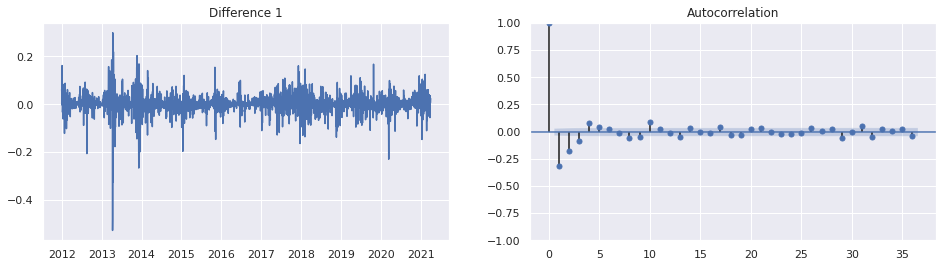

In [40]:
#3rd fiff
diff3 = transformed_df.diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(transformed_df)
ax1.set_title('Difference 1')
plot_acf(diff3, ax= ax2);

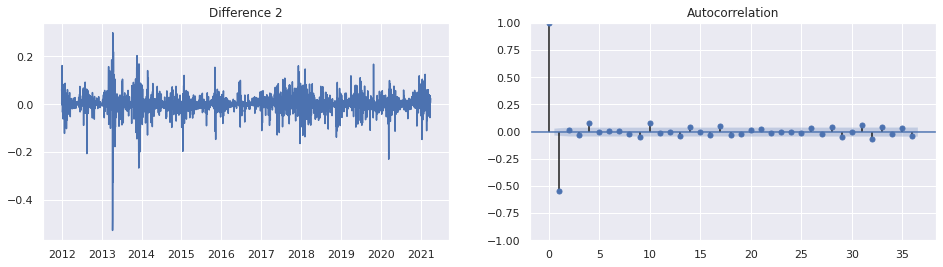

In [41]:
diff4 = transformed_df.diff().diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(transformed_df)
ax1.set_title('Difference 2')
plot_acf(diff4, ax= ax2);

The time series reaches stationary after one differencing because the autocorrolation plot for the 3rd differencing, the lag went into the negative zone. This indicates that the series might have been overdifferenced. 

Therefore, we can have d=1

In [42]:
!pip install pmdarima

To make sure that the interpretation is correct, we're going to use ndiff() package to find d value 

In [42]:
!pip3 uninstall statsmodels

Found existing installation: statsmodels 0.13.0
Uninstalling statsmodels-0.13.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.13.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.13.0


In [43]:
!pip3 install numpy scipy patsy pandas

In [44]:
!pip3 install statsmodels

  Using cached statsmodels-0.13.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


In [43]:
from pmdarima.arima.utils import ndiffs

In [44]:
ndiffs(df.Close.dropna(), test="adf") #deciding d for order of differencing 

1

**Find p**

Using Partial Correlation Plot to find p. Partial Auto correlation represent the correlation between the series and its lags. 

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


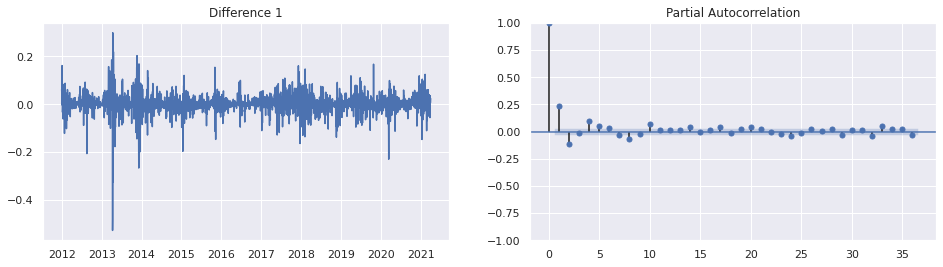

In [51]:
#plot PACF # first difference 
diff_p = log(df.Close).diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(diff_p)
ax1.set_title('Difference 1')
ax2.set_ylim(0, 5)
plot_pacf(diff_p, ax= ax2);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


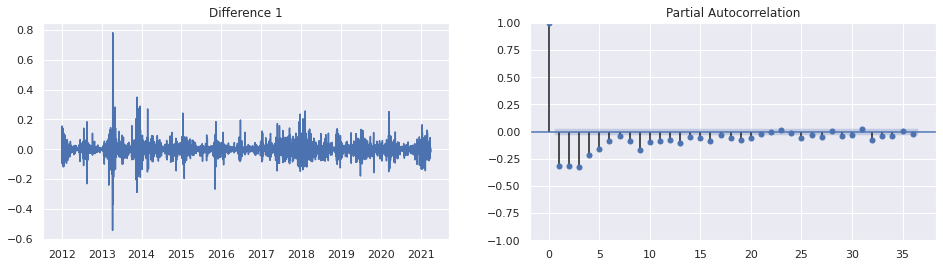

In [52]:
#plot PACF # first difference 
diff_p2 = log(df.Close).diff().diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(diff_p2)
ax1.set_title('Difference 1')
ax2.set_ylim(0, 5)
plot_pacf(diff_p2, ax= ax2);

We can observe that the PACF lag is as it's above the significant line and stoof out the most. 

**Finding q**

q is the order of the moving average (MA)term. 
Its the number of lagged forecast errors that should go into the ARIMA model
We also use ACF plot to find q 

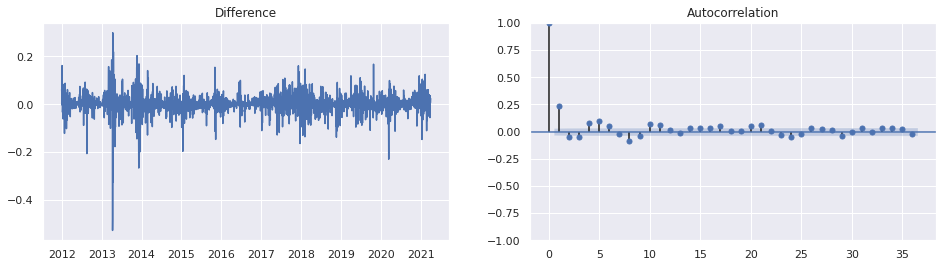

In [56]:
#first difference
diff_q= log(df.Close).diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(diff_q)
ax1.set_title('Difference')
ax2.set_ylim(0, 1)
plot_acf(diff_q, ax= ax2);

From observation, we can see the forecast error is about 7(Right at the shaded area)

### Fitting the model

In [254]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.arima_model as stats

In [255]:
#fitting the arima model 
# ARIMA model 
model = ARIMA(df.Close, order=(1,2,7))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local

In [256]:
model_fit = model.fit()
print(model_fit.summary()) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3379
Model:                 ARIMA(1, 2, 7)   Log Likelihood              -35274.267
Date:                Tue, 05 Oct 2021   AIC                          70566.533
Time:                        02:50:42   BIC                          70621.656
Sample:                             0   HQIC                         70586.241
                               - 3379                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9998      0.001  -1077.948      0.000      -1.002      -0.998
ma.L1         -0.9944      0.031    -32.252      0.000      -1.055      -0.934
ma.L2         -1.0228      0.038    -27.187      0.0

The summary displayed the predictors and coeficient for the model. For predictors with P-value more than 0.05, they will have no significance in the model. 

There are 7 MA values and 1 AR in the model.

**Splitting train and test sets**

In [257]:
n= int(len(df.Close)*0.8)
train_set= df.Close[:n]
test_set= df.Close[n:]

In [258]:
print(len(train_set))
print(len(test_set))

2703
676


In [259]:
#fitting into the train set 
model_train= ARIMA(train_set, order= (1,2,7))
result_train = model_train.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local

In [260]:
result_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2703
Model:                 ARIMA(1, 2, 7)   Log Likelihood              -28183.978
Date:                Tue, 05 Oct 2021   AIC                          56385.957
Time:                        02:52:01   BIC                          56439.069
Sample:                             0   HQIC                         56405.163
                               - 2703                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9994      0.003   -333.457      0.000      -1.005      -0.994
ma.L1         -0.9832      0.023    -42.488      0.000      -1.029      -0.938
ma.L2         -1.0277      0.038    -26.877      0.000      -1.103      -0.953
ma.L3          1.0065      0.047     21.592      0.000       0.915       1.098
ma.L4          0.0209      0.047      0.442      0.658      -0.072       0.113
ma.L5         -0.0261      0.047     -0.553      0.580      -0.118       0.066
ma.L6          0.0070      0.040      0.174      0.862      -0.072       0.085
ma.L7          0.0027      0.034      0.079      0.937      -0.063       0.069
sigma2      8.523e+07    1.5e-09   5.68e+16      0.000    8.52e+07    8.52e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             42958.92
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             3.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+31. Standard errors may be unstable.
"""

In [263]:
#fitting into the test set 
model_test= ARIMA(test_set, order= (1,2,7))
result_test = model_test.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local

In [264]:
result_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  676
Model:                 ARIMA(1, 2, 7)   Log Likelihood               -7079.161
Date:                Tue, 05 Oct 2021   AIC                          14176.321
Time:                        02:52:31   BIC                          14216.941
Sample:                             0   HQIC                         14192.050
                                - 676                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9984      0.065    -15.298      0.000      -1.126      -0.870
ma.L1         -1.0183      0.111     -9.146      0.000      -1.237      -0.800
ma.L2         -0.9960      0.180     -5.537      0.000      -1.348      -0.643
ma.L3          1.0243      0.138      7.398      0.000       0.753       1.296
ma.L4          0.0206      0.136      0.151      0.880      -0.247       0.288
ma.L5         -0.0078      0.128     -0.060      0.952      -0.260       0.244
ma.L6         -0.0228      0.094     -0.242      0.809      -0.207       0.162
ma.L7        5.38e-05      0.072      0.001      0.999      -0.141       0.141
sigma2      1.127e+08   2.02e-09   5.58e+16      0.000    1.13e+08    1.13e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              9220.07
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             3.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.86e+31. Standard errors may be unstable.
"""

In [265]:
#forecast 3 steps 
steps =3

fc, se, conf = result_test.forecast(steps)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [266]:
# out of sample forecast
print(fc)

4511.303650361495


The forcasted price for Bitcoin is 8734 $

In [267]:
# standard error of the forecast 
print(se)

4497.48547734566


In [268]:
#upper bound and lower bound confidence level 
print(conf)

4228.998602501423


In [269]:
fc = pd.Series(fc, index= test_set.index)
lower = pd.Series(conf, index= test_set.index)
upper = pd.Series(conf, index= test_set.index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'Upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


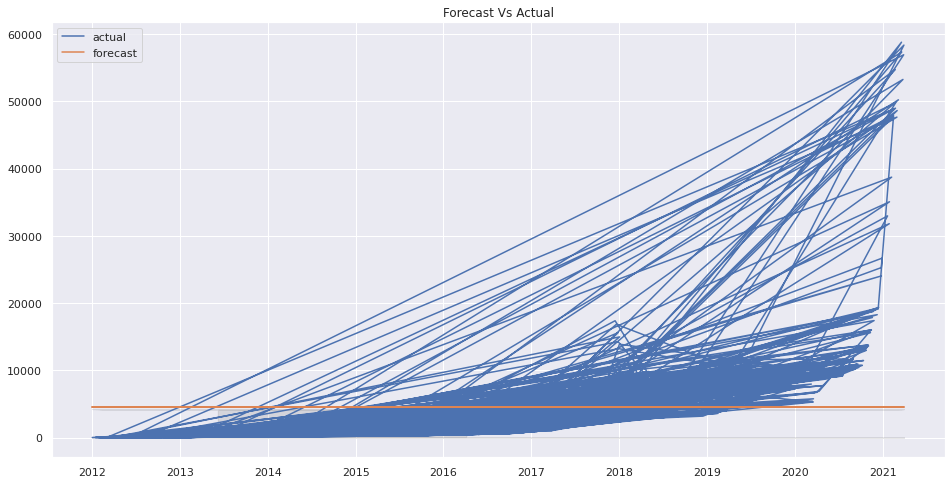

In [271]:
#plotting forcast values and test set 
plt.figure(figsize=(16, 8))
plt.plot(test_set, label= "actual")
plt.plot(fc, label= "forecast")


plt.fill_between(lower.index, upper, color= "k", alpha= 0.1)

plt.title("Forecast Vs Actual")
plt.legend(loc= "Upper Left")

# **Simple RNN**

Yihan Jia's part here

# **LSTM Model**

Chun Zhou and Vaibhav's part here

LSTM stands for long short-term memory networks. It is a variety of recurrent neural network (RNN) in the deep learning field. LSTM is effective when predicting sequence of data.

#**References**

1. "Bitcoin Price Prediction with LSTM". Ansel D'souza. https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm

2. How to Create an ARIMA Model for Time Series Forecasting in Python. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

3. How to Grid Search ARIMA Model Hyperparameters with Python. https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/